# Classifying Customers with a Decision Tree

The objective of this project is to classify customers into different income groups based on their gender, age, spending socre, profession and work experience. The dataset for the project contains data from 2000 customers. A decision tree has been built and trained on a training subset of the data and then tested on a testing subset.

## Imporitng libraries and dataset

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [7]:
#columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
#df = pd.read_csv('Iris.csv', skiprows=1, header=None, names=columns)

#dfx = pd.read_csv("breast-cancer.csv", usecols=["radius_mean", "perimeter_mean", "area_mean"])
#dfy = pd.read_csv("breast-cancer.csv", usecols=[1])
#df = pd.concat([dfx,dfy], axis=1)

df = pd.read_csv("customers.csv", usecols=["Gender", "Age", "Annual Income ($)", "Spending Score (1-100)", "Profession", "Work Experience", "Family Size"])


## Data preprocessing 

In [42]:
df.shape

(2000, 7)

In [43]:
df.head()

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,Male,19,15000,39,Healthcare,1,4
1,Male,21,35000,81,Engineer,3,3
2,Female,20,86000,6,Engineer,1,1
3,Female,23,59000,77,Lawyer,0,2
4,Female,31,38000,40,Entertainment,2,6


<AxesSubplot:>

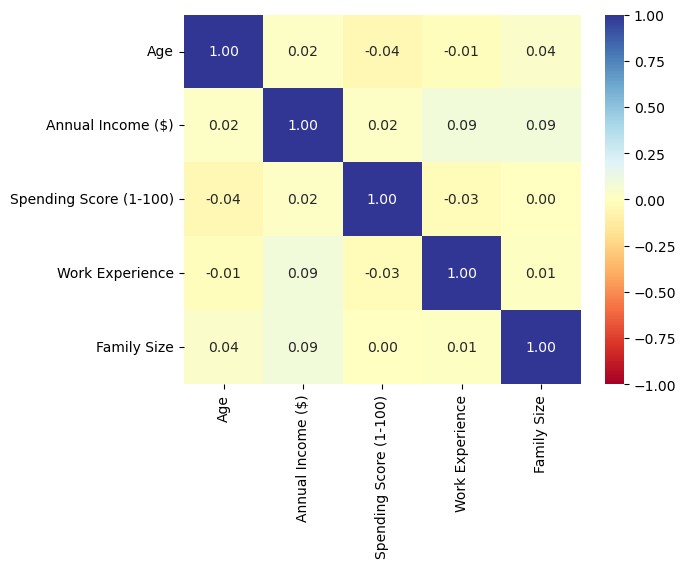

In [41]:
sns.heatmap(df.corr(), cmap="RdYlBu", vmin=-1, center=0, annot=True, fmt=".2f")

#### Dropping observations with missing values 

In [6]:
df.isnull().sum()

Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64

In [7]:
df.dropna(axis=0, subset=["Profession"], inplace=True)

In [8]:
df.Profession.unique()

array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing'], dtype=object)

#### Dropping observations with absurd values 

In [9]:
df.describe()

,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
count,1965.000000,1965.000000,1965.000000,1965.000000,1965.000000
mean,48.894656,110616.009669,51.078880,4.092621,3.757252
std,28.414889,45833.860195,27.977176,3.926459,1.968335
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25.000000,74350.000000,28.000000,1.000000,2.000000
50%,48.000000,109759.000000,50.000000,3.000000,4.000000
75%,73.000000,149095.000000,75.000000,7.000000,5.000000
max,99.000000,189974.000000,100.000000,17.000000,9.000000


Since many observations include children and teenagers with multiple years of work experience in professions like healthcare, engineering, law, it would be logical to include only the observations with adults (18 years of age or older).

In [10]:
df = df[df.Age >= 18]
df.shape

(1638, 7)

#### One-hot encoding

In [11]:
df["Gender"] = np.where(df["Gender"]=="Male", 1, 0)

In [12]:
df["Profession"].unique()

array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing'], dtype=object)

In [13]:
df["P_Healthcare"] = np.where(df["Profession"]=="Healthcare", 1, 0)
df["P_Engineer"] = np.where(df["Profession"]=="Engineer", 1, 0)
df["P_Lawyer"] = np.where(df["Profession"]=="Lawyer", 1, 0)
df["P_Entertainment"] = np.where(df["Profession"]=="Entertainment", 1, 0)
df["P_Artist"] = np.where(df["Profession"]=="Artist", 1, 0)
df["P_Executive"] = np.where(df["Profession"]=="Executive", 1, 0)
df["P_Doctor"] = np.where(df["Profession"]=="Doctor", 1, 0)
df["P_Homemaker"] = np.where(df["Profession"]=="Homemaker", 1, 0)
df["P_Marketing"] = np.where(df["Profession"]=="Marketing", 1, 0)

In [14]:
df.drop("Profession", axis=1, inplace=True)

#### Creating Income Groups 

In [15]:
df["Income Group"] = 0
df.loc[(df["Annual Income ($)"]<=150000), "Income Group"] = "Low/Middle Income"
#df.loc[((df["Annual Income ($)"]>50000) & (df["Annual Income ($)"]<=150000)), "Income Group"] = "Middle Income"
df.loc[(df["Annual Income ($)"]>150000), "Income Group"] = "Upper Income"

In [16]:
df.drop("Annual Income ($)", axis=1, inplace=True)

In [17]:
df["Income Group"].value_counts(normalize=True)

Low/Middle Income    0.765568
Upper Income         0.234432
Name: Income Group, dtype: float64

In [18]:
df.head()

,Gender,Age,Spending Score (1-100),Work Experience,Family Size,P_Healthcare,P_Engineer,P_Lawyer,P_Entertainment,P_Artist,P_Executive,P_Doctor,P_Homemaker,P_Marketing,Income Group
0,1,19,39,1,4,1,0,0,0,0,0,0,0,0,Low/Middle Income
1,1,21,81,3,3,0,1,0,0,0,0,0,0,0,Low/Middle Income
2,0,20,6,1,1,0,1,0,0,0,0,0,0,0,Low/Middle Income
3,0,23,77,0,2,0,0,1,0,0,0,0,0,0,Low/Middle Income
4,0,31,40,2,6,0,0,0,1,0,0,0,0,0,Low/Middle Income


## Building the Decision Tree

In [19]:
class Node():
    
    def __init__(self, left=None, right=None, feature=None, threshold=None, information_gain=None, node_class=None, depth=None):
        self.left = left
        self.right = right
        self.feature = feature
        self.threshold = threshold
        self.information_gain = information_gain
        
        self.node_class = node_class    
        self.depth = depth

In [20]:
class DecisionTree():
    tree_depth = 0
    def __init__(self, min_samples, max_depth, root=None):
        self.root = None
        self.min_samples = min_samples
        self.max_depth = max_depth
        
    def GrowTree(self, data, depth):
        
        if self.CheckMinSamples(data, self.min_samples) and self.CheckMaxDepth(depth, self.max_depth):
            information_gain = self.GetDecision(data)["information_gain"]
            feature = self.GetDecision(data)["feature"]
            threshold = self.GetDecision(data)["threshold"]
            if information_gain>0:
                left_data = self.Split(data, feature, threshold)["left"]
                right_data = self.Split(data, feature, threshold)["right"]
                left = self.GrowTree(left_data, depth+1)
                right = self.GrowTree(right_data, depth+1)
                return Node(left, right, feature, threshold, information_gain, None, depth)
  
        return self.GetLeafNode(data, depth)
    
    def CheckMinSamples(self, data, min_samples):
        if data.shape[0]>min_samples:
            return True
        else:
            return False
        
    def CheckMaxDepth(self, current_depth, max_depth):
        if current_depth < max_depth:
            return True
        else:
            return False
        
    def GetDecision(self, data):
        features = list(data.columns)
        entropy = self.GetEntropy(data)
        best_feature_index = None
        best_feature = None
        best_threshold = None
        best_information_gain = -np.inf
        
        for feature in features[0:-1]:
            thresholds = list(data[feature].unique())
            for threshold in thresholds:
                temp_information_gain = self.GetInformationGain(data, feature, threshold, "gini")
                if temp_information_gain > best_information_gain:
                    best_feature_index = features.index(feature)
                    best_feature = feature
                    best_threshold = threshold
                    best_information_gain = temp_information_gain
                else:
                    continue
                    
        decision_dict = {"feature": best_feature, "threshold": best_threshold, "information_gain": best_information_gain}
        return decision_dict
    
    def Split(self, data, feature, threshold):
        left_data = data[data[feature]<=threshold]
        right_data = data[data[feature]>threshold]
        split_dict = {"left":left_data, "right":right_data}
        return split_dict
    
    def GetEntropy(self, data):
        class_probabilities = data.iloc[:,-1].value_counts(normalize=True)
        entropy = np.dot(-class_probabilities,np.log2(class_probabilities))
        return entropy
    
    def GetGini(self, data):
        class_probabilities = data.iloc[:,-1].value_counts(normalize=True)
        gini = 1 - np.sum(np.square(class_probabilities))
        return gini
    
    def GetInformationGain(self, data, feature, threshold, gini="gini"):
        if gini=="gini":
            parent_entropy = self.GetGini(data)
        else:
            parent_entropy = self.GetEntropy(data)
        
        left_data = self.Split(data, feature, threshold)["left"]
        proportion_left_data = (left_data.shape[0]/data.shape[0])
        right_data = self.Split(data, feature, threshold)["right"]
        proportion_right_data = right_data.shape[0]/data.shape[0]
        
        if gini=="gini":
            children_entropy = proportion_left_data*self.GetGini(left_data)+proportion_right_data*self.GetGini(right_data)
        else:
            children_entropy = proportion_left_data*self.GetEntropy(left_data)+proportion_right_data*self.GetEntropy(right_data)
        
        information_gain = parent_entropy-children_entropy
        return information_gain
    
    def GetLeafNode(self, data, depth):
        class_sizes = dict(data.iloc[:,-1].value_counts(ascending=False))
        node_class = list(class_sizes.keys())[0]
        leaf_node = Node(node_class=node_class, depth=depth)
        return leaf_node
        
    def PrintTree(self, node):
        if node.node_class!=None:
            #return node.node_class
            print("Level", node.depth, "Leaf Node: ", node.node_class)
        else:
            print("Level", node.depth, "Decision Node: ", node.feature, "<=", node.threshold)
            self.PrintTree(node.left)
            self.PrintTree(node.right)

    def fit(self, data):
        self.root = self.GrowTree(data, 1)
        
    def Predict(self, data, node):
        predictions = []
        for i in range(len(data)):
            predictions.append(self.GetPrediction(data.iloc[i,0:-1], node))
        predictions = pd.DataFrame(predictions, columns=[data.columns[-1]])
        return predictions
        
    def GetPrediction(self, X, node):
        if node.node_class != None:
            return node.node_class
        feature_value = X[node.feature]
        if feature_value<=node.threshold:
            return self.GetPrediction(X, node.left)
        elif feature_value>node.threshold:
            return self.GetPrediction(X, node.right)

## Fitting the model 

In [21]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.30, random_state=40)

In [22]:
X_train, X_test, Y_train, Y_test  = pd.DataFrame(X_train), pd.DataFrame(X_test), pd.DataFrame(Y_train), pd.DataFrame(Y_test)
X_train.columns = df.columns[0:-1]
X_test.columns = df.columns[0:-1]
Y_train.columns = [df.columns[-1]]
Y_test.columns = [df.columns[-1]]
training_dataset = pd.concat([X_train, Y_train], axis=1)
testing_dataset = pd.concat([X_test, Y_test], axis=1)

In [23]:
DecisionTreeClassifier = DecisionTree(0.01*len(X_train), 4)

In [24]:
DecisionTreeClassifier.fit(training_dataset)
DecisionTreeClassifier.PrintTree(DecisionTreeClassifier.root)

Level 1 Decision Node:  Family Size <= 4
Level 2 Decision Node:  Work Experience <= 6
Level 3 Decision Node:  Age <= 59
Level 4 Leaf Node:  Low/Middle Income
Level 4 Leaf Node:  Low/Middle Income
Level 3 Decision Node:  Age <= 89
Level 4 Leaf Node:  Low/Middle Income
Level 4 Leaf Node:  Low/Middle Income
Level 2 Decision Node:  Age <= 44
Level 3 Decision Node:  Work Experience <= 6
Level 4 Leaf Node:  Low/Middle Income
Level 4 Leaf Node:  Upper Income
Level 3 Decision Node:  Spending Score (1-100) <= 97
Level 4 Leaf Node:  Low/Middle Income
Level 4 Leaf Node:  Upper Income


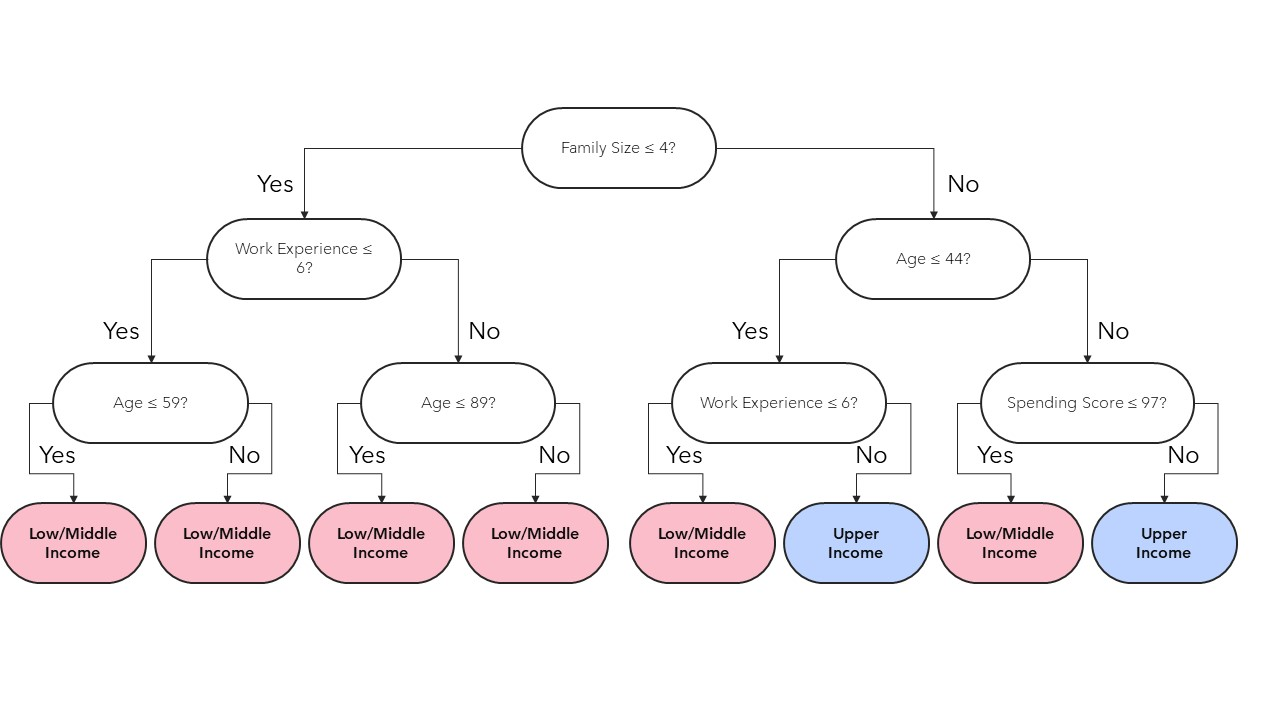

## Testing the Model

In [25]:
train_predictions = DecisionTreeClassifier.Predict(training_dataset, DecisionTreeClassifier.root)
test_predictions = DecisionTreeClassifier.Predict(testing_dataset, DecisionTreeClassifier.root)

In [26]:
print(f"The decision tree achieved a training accuracy score of: {accuracy_score(Y_train, train_predictions)}")
print(f"The decision tree achieved a testing accuracy score of: {accuracy_score(Y_test, test_predictions)}")

The decision tree achieved a training accuracy score of: 0.7661431064572426
The decision tree achieved a testing accuracy score of: 0.7479674796747967


## The End